# Introduction

<p> The US Border Crossing Entry dataset contains information regarding inbound US border land crossings. 
The borders considered are the US' land borders with Mexico and with Canada. The following is an EDA of the dataset to play around with both the data and some common python libraries. 
</p>

### First, let's import the required modules and the dataset itself!

The required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

Importing the dataset: 

In [2]:
df = pd.read_csv('Data/Border_Crossing_Entry_Data.csv')

Let's not forget setting up our colours:

['#8bdab2', '#40b7ad', '#348fa7', '#37659e', '#413d7b', '#2e1e3b']


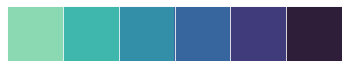

In [3]:
sns.set_style('darkgrid')
pal = sns.color_palette('mako_r').as_hex() # getting my favourite color palette
print(pal)
sns.color_palette('mako_r')
sns.palplot(sns.color_palette('mako_r'))

### Now let's get some info about the data...

The initial format of the data is:

In [4]:
df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,US-Canada Border,03/01/2019 12:00:00 AM,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


Let's get some preliminary info about the dataset.

In [5]:
print("There are", len(df), "crossings in the dataset.")
print("There are", len(df.columns), "columns in the dataset.")

There are 346733 crossings in the dataset.
There are 8 columns in the dataset.


What columns does the datset have?

In [6]:
print(df.columns)
df.sample()

Index(['Port Name', 'State', 'Port Code', 'Border', 'Date', 'Measure', 'Value',
       'Location'],
      dtype='object')


,Port Name,State,Port Code,Border,Date,Measure,Value,Location
234667,Champlain-Rouses Point,New York,712,US-Canada Border,07/01/2003 12:00:00 AM,Trucks,32251,POINT (-73.45 45.01)


Most of the column names are pretty self-explantory. For the ones that might be a little confusing: 
    <ol>
    <li> Measure = the method of land travel </li>
    <li> Value = the number of crossings made at the port on that date </li>
    </ol>
 
We can see that the Location column stores a POINT object which is something to investigate later. Similarly, it seems that each port has 3 unique identifiers, so it might be beneficial to only keep one.

Now let's find out the types of values stored in each column:

In [7]:
df.dtypes

Port Name    object
State        object
Port Code     int64
Border       object
Date         object
Measure      object
Value         int64
Location     object
dtype: object

There are 2 columns of type 'int64' as expected, and 6 columns of 'object' type. 
    The next step is to look for missing and/or null values. However since this datset is imported from Kaggle (who is notorious for pretty clean datasets), we shouldn't expect to see many.

In [8]:
df.isnull().sum()

Port Name    0
State        0
Port Code    0
Border       0
Date         0
Measure      0
Value        0
Location     0
dtype: int64

There are no missing or null entries. No surprises here so let's move on. 

*Note that if there were such entries, it would be worthwhile to check the total number and/or their distribution, and then either delete the corresponding rows, or apply a heuristic to fill these entries. 

Before we begin the next step, let's describe the Value column of our dataset and store some values:

In [9]:
df['Value'].describe()

count    3.467330e+05
mean     2.818767e+04
std      1.518588e+05
min      0.000000e+00
25%      0.000000e+00
50%      9.000000e+01
75%      2.483000e+03
max      4.447374e+06
Name: Value, dtype: float64

In [10]:
value_mean = df['Value'].mean()
value_std = df['Value'].mean()

### Ok, now we clean and prep the data!

#### Take out the outliers!

We noted above that there are no missing and/or null entries, so the next step is to check for outliers. The easy way to do this would be using only the Value column. The hard way would be to split the data using grouping based on at least one other column. 

In [11]:
print('There are', df['Port Name'].nunique(), 'unique values in the Port Name column.')
print('There are', df['State'].nunique(), 'unique values in the State column.')
print('There are', df['Border'].nunique(), 'unique values in the Border column.')
print('There are', df['Measure'].nunique(), 'unique values in the Measure column.')

There are 116 unique values in the Port Name column.
There are 15 unique values in the State column.
There are 2 unique values in the Border column.
There are 12 unique values in the Measure column.


Hmm, for now, let's group by the Border column, and find outliers that way. First divide the dataset accordingly and then we'll take out outliers by using the standard deviation method. That is, anything outside of x standard deviations is considered an outlier. Let's use x = 4.

In [12]:
US_MEX_df = df[df.Border == 'US-Mexico Border']
US_CAN_df = df[df.Border == 'US-Canada Border']

In [13]:
x = 4

# find the means and stds for each dataset
us_mex_mean = US_MEX_df['Value'].mean()
us_mex_std = US_MEX_df['Value'].std()

us_can_mean = US_CAN_df['Value'].mean()
us_can_std = US_CAN_df['Value'].std()

# find the upper and lower bounds for each dataset
us_mex_ub = us_mex_mean + x*us_mex_std
us_mex_lb = us_mex_mean - x*us_mex_std

us_can_ub = us_can_mean + x*us_can_std
us_can_lb = us_can_mean - x*us_can_std

# filter out the rows in df 
df = df[((us_mex_lb < df['Value']) & (df['Value'] < us_mex_ub) & (df['Border'] == 'US-Mexico Border')) | 
        ((us_can_lb < df['Value']) & (df ['Value'] < us_can_ub) & (df['Border'] == 'US-Canada Border'))]

Let's see if it worked:

In [14]:
print('The are now', len(df), 'crossings in the dataset.')

The are now 343671 crossings in the dataset.


Success! Dividing the dataset by the Border column allowed us to find outliers specific to each borderline, and obtain more accurate results for each. Doing one calculation ('the easy way') may have eliminated the effects of each borderline on the outliers. 

Next, let's take a closer look at each column and reformat some of the data so it's easier to 'type' later on. We'll go in order of columns (for the most part)

#### Port Name and Port Code

We'll truncate the column names to 'Name' and 'Code' so we can use dot notation (yay!) moving forward.

In [15]:
df.rename({'Port Name': 'Name', 'Port Code': 'Code'}, axis=1, inplace=True)
print(df.columns)

Index(['Name', 'State', 'Code', 'Border', 'Date', 'Measure', 'Value',
       'Location'],
      dtype='object')


#### Border

We skip State for now, and move-on to Border. There are 2 unique values for Border: {US-Mexico Border, US-Canada Border}. Let's double check and then truncate these:

In [16]:
# define function that modifies a string
def border_mod(crossing):
    return crossing.Border[3:9] # remove 'US' and 'Border'

df.Border = df.apply(border_mod, axis=1)

In [17]:
df.head()

,Name,State,Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,Mexico,03/01/2019 12:00:00 AM,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,Canada,03/01/2019 12:00:00 AM,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,Mexico,03/01/2019 12:00:00 AM,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,Mexico,03/01/2019 12:00:00 AM,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,Canada,03/01/2019 12:00:00 AM,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


#### Date

Looking at the Date column, each entry includes the time as well. I suspect that the time for all entries is also set to 12:00:00 AM otherwise the length of the dataset would be much longer.

I also suspect that the data is provided in aggregate amounts for each month so let's compare how many different dates we have to the number of months in the period. If they're the same, then we don't need the time column at all.

In [18]:
# First let's convert to datetime so we can get rid of the time
df.Date = pd.to_datetime(df.Date)

max_date = df.Date.max()
min_date = df.Date.min()

num_months = (max_date.year - min_date.year)*12 + (max_date.month - min_date.month) + 1
print('The date range for the dataset is from', min_date.date(), 'to', max_date.date())
print('There are', num_months, 'months in this time period.')
print('There are', df.Date.nunique(), 'different months in the dataset.')

The date range for the dataset is from 1996-01-01 to 2019-03-01
There are 279 months in this time period.
There are 279 different months in the dataset.


#### Measure and Value

How many unique values of Measure are there? What are they?

In [19]:
print('There are', df.Measure.nunique(), 'methods of land border crossing.')
df.Measure.unique()

There are 12 methods of land border crossing.


array(['Trucks', 'Rail Containers Full', 'Trains',
       'Personal Vehicle Passengers', 'Bus Passengers',
       'Truck Containers Empty', 'Rail Containers Empty',
       'Personal Vehicles', 'Buses', 'Truck Containers Full',
       'Pedestrians', 'Train Passengers'], dtype=object)

How many border crossings were there in January 1996? What about in March 2019? How many ports were open during each time period?

In [20]:
# January 1996
jan96_df = df[df.Date == pd.to_datetime('01-01-1996')]
num_ports_96 = jan96_df.Name.nunique()
min_96 = jan96_df.Value.min()
max_96 = jan96_df.Value.max()

# March 2019
mar19_df = df[df.Date == pd.to_datetime('03-01-1998')]
num_ports_19 = mar19_df.Name.nunique()
min_19 = mar19_df.Value.min()
max_19 = mar19_df.Value.max()

print('In January 1996, there were', num_ports_96, 'ports and [', min_96, ',', max_96, '] total crossings.')
print('In March 2019, there were', num_ports_19, 'ports and [', min_19, ',', max_19, '] total crossings.')
print('A', round((max_19/max_96 - 1)*100, 2), '% increase.')


In January 1996, there were 103 ports and [ 0 , 802136 ] total crossings.
In March 2019, there were 103 ports and [ 0 , 1183641 ] total crossings.
A 47.56 % increase.


In nearly two and half decades, the number of total border crossings over 103 ports increased by almost 50%.

#### Location

The location column contains POINT objects consisting of the longitude and latitude. We determined before that it seems to be a 3rd unique identifier along with Name and Code. Before determining whether we still need the column or if we need to make changes, let's make sure it includes only primary keys. If so, then the number of unique values in each of Name, Code and Locations will be equal.

In [21]:
print('There are', df.Name.nunique(), 'port names.')
print('There are', df.Code.nunique(), 'port codes.')
print('There are', df.Location.nunique(), 'locations.')

There are 116 port names.
There are 117 port codes.
There are 224 locations.


Uh oh! There is a discrepancy here contradicting our hypothesis. All values should be the same. Since there is 1 more port code than port name, it might be that two unique codes correspond to the same port name in different locations. Let's find out:

In [22]:
dup_df = df[['Name', 'Code']].drop_duplicates()
dup_df[dup_df.Name.duplicated(keep=False)]

,Name,Code
29,Eastport,3302
217,Eastport,103


There seems to be two Eastport port names with 2 distinct port codes. This is potentially an error in the dataset. Let's investigate.

In [23]:
df.loc[[29,217]]

,Name,State,Code,Border,Date,Measure,Value,Location
29,Eastport,Idaho,3302,Canada,2019-03-01,Trains,101,POINT (-116.18027999999998 48.99944)
217,Eastport,Maine,103,Canada,2019-03-01,Trucks,165,POINT (-66.99387 44.90357)


This is not an error but instead there are two ports in different locations and codes with the same name. Moving forward, we can rename one of the two ports so it can be appropriately referenced.

In [24]:
df.at[(df.Name == 'Eastport') & (df.State == 'Maine'), 'Name'] = 'Eastport_M'
df.loc[df.Name == 'Eastport_M'].head()

,Name,State,Code,Border,Date,Measure,Value,Location
217,Eastport_M,Maine,103,Canada,2019-03-01,Trucks,165,POINT (-66.99387 44.90357)
249,Eastport_M,Maine,103,Canada,2019-03-01,Pedestrians,3,POINT (-66.99387 44.90357)
428,Eastport_M,Maine,103,Canada,2019-03-01,Personal Vehicle Passengers,12108,POINT (-66.99387 44.90357)
576,Eastport_M,Maine,103,Canada,2019-03-01,Personal Vehicles,7831,POINT (-66.99387 44.90357)
665,Eastport_M,Maine,103,Canada,2019-03-01,Truck Containers Full,97,POINT (-66.99387 44.90357)


Ok, cool. Now that we've dealt with the first discrepancy, let's deal with the second. There are 117 port codes but 224 locations. This implies either an error or some port codes have at least 2 two locations assigned to them. 

In [25]:
code_locs = df[['Code', 'Location']].drop_duplicates()
code_locs

,Code,Location
0,2507,POINT (-115.48433000000001 32.67524)
1,108,POINT (-67.94271 47.16207)
2,2506,POINT (-117.05333 32.57333)
3,2604,POINT (-110.93361 31.340279999999996)
4,715,POINT (-73.44253 44.990010000000005)
...,...,...
22183,3020,POINT (-117.62999999999998 49)
22492,3015,POINT (-117.83 49)
67202,3312,POINT (-105.16 49)
114768,3402,POINT (-97.21 49)


There are 229 possible (code, location) combinations. Since there are only 224 unique locations, this implies that some port locations might have at least 2 port codes assigned to them. Or, there may in fact be two or more ports at the same location! 

In [26]:
codes = code_locs.groupby(['Code']).count()
codes

,Location
Code,
101,2
103,2
104,2
105,2
106,2
...,...
3801,2
3802,2
3803,2


As expected, some codes have more than 1 location assigned to them. But how can a port exist in 2 different locations simultaneously? It might be that at the time of recording, a slightly different longitude and latitude was used.

Let's check the reverse.

In [27]:
locations = code_locs.groupby(['Location']).count()
locations

,Code
Location,
POINT (-100.05 49),1
POINT (-100.05863 48.81369),1
POINT (-100.49917 28.70889),1
POINT (-100.51 28.71),1
POINT (-100.56 49),1
...,...
POINT (-99.38250000000001 48.95),1
POINT (-99.50722 27.50611),1
POINT (-99.51 27.5),1


Ok, nothing so far, but let's count the number of unique values.

In [28]:
locations.Code.unique()

array([1, 2])

Great, so now we know that there are some locations with 2 codes assigned. Let's visualize so we can get a better idea:

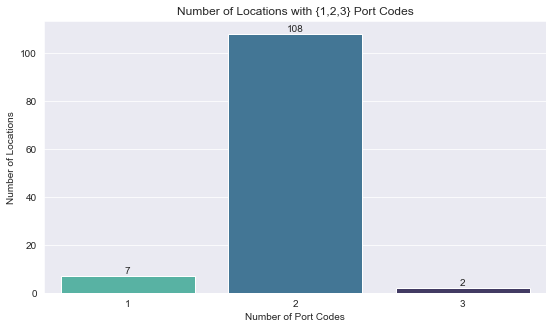

In [29]:
pt.figure(figsize=(9,5))
sns.set_style('darkgrid')
ax = sns.countplot(x='Location', data=codes, palette='mako_r')
pt.title('Number of Locations with {1,2,3} Port Codes')
pt.xlabel('Number of Port Codes')
pt.ylabel('Number of Locations')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha='center')

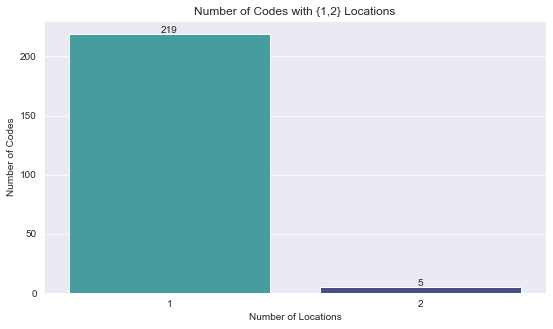

In [30]:
pt.figure(figsize=(9,5))
ax1 = sns.countplot(x='Code', data=locations, palette='mako_r')
pt.title('Number of Codes with {1,2} Locations')
pt.xlabel('Number of Locations')
pt.ylabel('Number of Codes')
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha='center')

From the above graphs, we see that 108 locations have 2 port codes assigned to them. 7 locations have exactly 1 code assigned, and 2 locations have 3 codes assigned. 

Conversely, 219 codes have 1 location assigned to them, and 5 codes have 2 locations assigned. 

Let's determine the ports and locations which share one or the either. First find the (code, location) combinations that correspond to the port codes which have exactly 2 locations assigned to them.

In [31]:
ind = locations[locations.values == 2].index
two_locations = code_locs[code_locs['Location'].isin(ind)]
two_locations

,Code,Location
4,715,POINT (-73.44253 44.990010000000005)
15,3323,POINT (-109.67761 48.54863)
79,3426,POINT (-95.81074 48.77518)
92,3425,POINT (-95.81074 48.77518)
302,3325,POINT (-109.67761 48.54863)
4212,706,POINT (-73.44253 44.990010000000005)
19150,3015,POINT (-117.62999999999998 49)
19267,3020,POINT (-117.83 49)
22183,3020,POINT (-117.62999999999998 49)
22492,3015,POINT (-117.83 49)


This table represents codes which have 2 unique locations, and locations which have 2 unique codes. It is pretty easy to see that code 3015 and 3020 each have 2 unique locations. Thus their corresponding locations also have 2 unique codes each. 

Let's look at code 3015 closer:

In [32]:
df.loc[[19150, 22492]]

,Name,State,Code,Border,Date,Measure,Value,Location
19150,Boundary,Washington,3015,Canada,2017-03-01,Rail Containers Empty,525,POINT (-117.62999999999998 49)
22492,Boundary,Washington,3015,Canada,2016-12-01,Rail Containers Full,720,POINT (-117.83 49)


Both entries have the same Name, State, Code and Border implying that these should have the same Location. However the Location is different but only slightly by a few decimal points. 

We can answer our previous question now: two ports can have two unique locations because of a slight discrepancy in recording the longitude and latitude points.

Now let's determine all such combinations from the above combination table.

In [33]:
combo = set()
for locs in two_locations.Location.tolist():
    codes = two_locations.loc[two_locations.Location == locs].Code.tolist()
    combo.add(tuple(codes))
combo

{(715, 706), (3015, 3020), (3020, 3015), (3323, 3325), (3426, 3425)}

As mentioned above, 3015 and 3020 both have 2 unique locations each, so we they show up twice in our combinations list as expected. Note that order does not matter. Let's look at one such combination:

In [34]:
df.loc[[4, 4212]]

,Name,State,Code,Border,Date,Measure,Value,Location
4,Trout River,New York,715,Canada,2019-03-01,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)
4212,Cape Vincent,New York,706,Canada,2018-10-01,Personal Vehicle Passengers,1218,POINT (-73.44253 44.990010000000005)


We can see that at this particular location, there are two different ports with their unique code. Let's see what happens when we get all rows with this location and their unique Name:

In [35]:
df.loc[df.Location == df.loc[4,'Location']].Name.unique()

array(['Trout River', 'Cape Vincent'], dtype=object)

This confirms that there are in fact two different ports located at the same place. 

Thus, even though the Location is meant to be a key identifier, it does not do its job and introduces confusion in the dataset. However, since we know why there are more unique Location values than unique port Codes, we will keep the column for now. If there is a need to delete later, we can do so with confidence.

### Visualize!

Now that we've prepped and understood our data elements individually, let's connect the dots and explore some relationships in the data!

#### Types of Movement

From before, we know there are 12 unique values for Measure. Let's see how their counts compare with each other.

In [36]:
movements = df.groupby(['Measure']).sum().Value.to_frame()
movements

,Value
Measure,
Bus Passengers,142330871
Buses,8543756
Pedestrians,1042990570
Personal Vehicle Passengers,2713888141
Personal Vehicles,1939194943
Rail Containers Empty,21139444
Rail Containers Full,38288393
Train Passengers,6197450
Trains,903864


Text(0, 0.5, 'Number of Crossings')

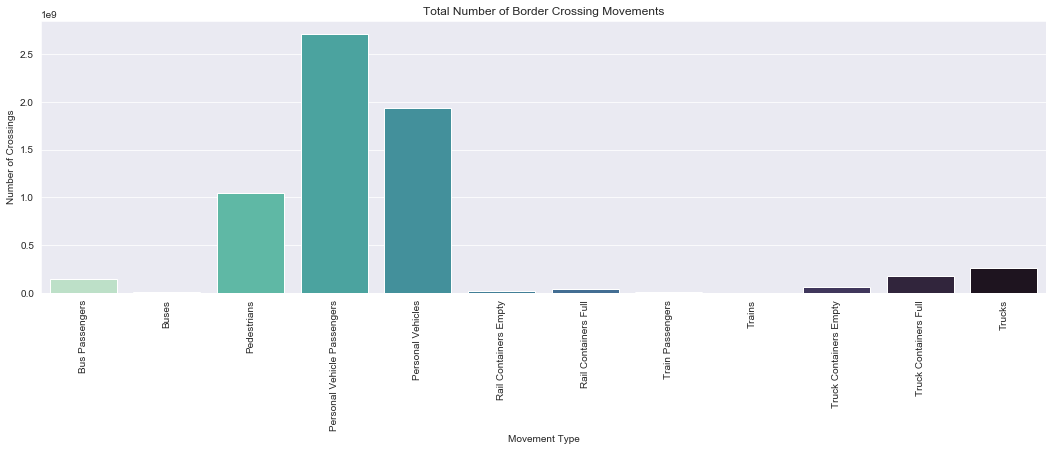

In [37]:
pt.figure(figsize=(18,5))
ax = sns.barplot(x=movements.index, y='Value', data=movements, palette='mako_r')
pt.xticks(rotation=90)
pt.title('Total Number of Border Crossing Movements')
pt.xlabel('Movement Type')
pt.ylabel('Number of Crossings')

In [38]:
print(movements.Value.idxmax(), 'contributes the most number of crossings with', movements.Value.max(), '.')
print(movements.Value.idxmin(), 'contributes the least number of crossings with', movements.Value.min(), '.')

Personal Vehicle Passengers contributes the most number of crossings with 2713888141 .
Trains contributes the least number of crossings with 903864 .


The above results are consistent with what we would expect. Personal vehicles (POV) are the most accessible transportation means, and each vehicle can carry a varying number of people. Hence POV is the second highest bar, and once the total number of passengers in those vehicles are considered, POV Passengers yield the highest bar. However, due to the ambiguity of the dataset, the question remains whether there is any double counting between these two groups. 

Something unexpected is seeing Pedestrians have the third highest number of border crossings; just over a billion! It is also surprising to see all forms of Truck transport be on the lower end of crossings since North American trade by land is a huge industry. Bus routes that cross a border are very rare which explains the low count, and slightly higher Bus Passenger count since one bus can have many passengers. Similarly, train tracks are much less common than roads, especially those that cross a land border, so we would expect this number to be severely low, as the plot confirms.  

Before going any further, it might be beneficial to split the movement types into some obvious categories:

In [39]:
people = ['Bus Passengers', 'Pedestrians', 'Personal Vehicle Passengers', 'Train Passengers']
single_vehicle = ['Personal Vehicles']
commercial = ['Buses', 'Rail Containers Empty', 'Rail Containers Full', 'Trains', 'Truck Containers Empty',
              'Truck Containers Full', 'Trucks']

passengers = df.loc[df.Measure.isin(people)]
pov = df.loc[df.Measure.isin(single_vehicle)]
comm = df.loc[df.Measure.isin(commercial)]

Let's see how passenger movement has changed over the years:

In [40]:
dates = list(passengers.Date.unique())[::-1]
p = {i:[0]*279 for i in range(4)}
pass_move = pd.DataFrame.from_dict(p, orient='index', columns=dates).reindex(people).fillna(0)

for psgr in range(len(passengers)):
    val = passengers.iloc[psgr].Value
    date = passengers.iloc[psgr].Date
    move = passengers.iloc[psgr].Measure
    pass_move.at[move, date] += val

pass_move.head()

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01
Bus Passengers,299911.0,320976.0,359668.0,454548.0,562319.0,569653.0,621553.0,623376.0,521521.0,501978.0,...,310507.0,480230.0,458659.0,340770.0,297462.0,256526.0,253580.0,269981.0,201409.0,266652.0
Pedestrians,3138859.0,2994503.0,3508484.0,3085717.0,2945140.0,2767772.0,2878658.0,2914940.0,2675729.0,2807338.0,...,3620173.0,3996851.0,3934833.0,3578550.0,3947964.0,3981241.0,4340119.0,3908833.0,3428115.0,4247273.0
Personal Vehicle Passengers,7280932.0,8346739.0,8120721.0,7947652.0,7839736.0,7543357.0,7901112.0,7120145.0,8820197.0,9803536.0,...,10122702.0,11066674.0,10849302.0,10105468.0,9995615.0,9529805.0,10429078.0,9455313.0,8264327.0,9855963.0
Train Passengers,13803.0,12643.0,13769.0,16904.0,17564.0,23691.0,30317.0,32205.0,19873.0,17083.0,...,44468.0,49014.0,56511.0,30229.0,17560.0,12737.0,13708.0,13749.0,10093.0,14172.0


Text(0.5, 25.0, 'Date')

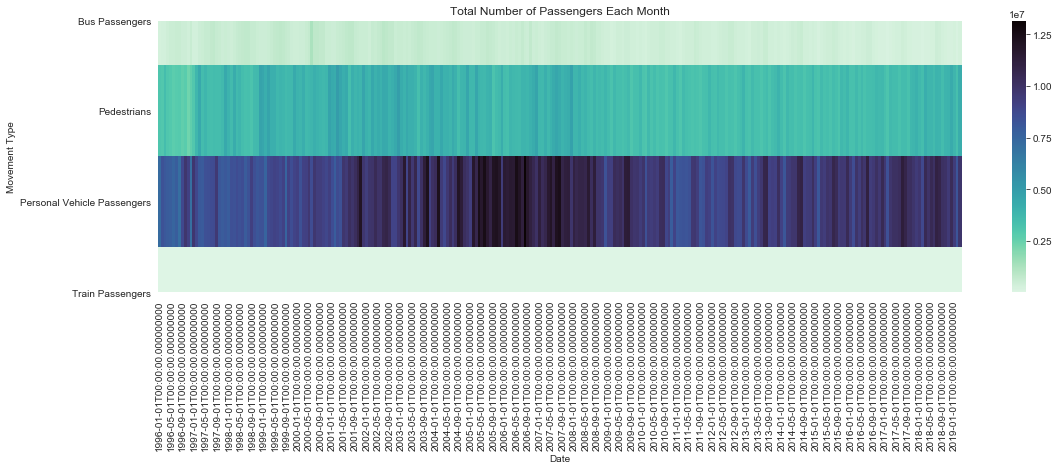

In [41]:
pt.figure(figsize=(18,5))
cmap = sns.cm.mako_r
sns.heatmap(pass_move, cmap=cmap)
pt.title('Total Number of Passengers Each Month')
pt.ylabel('Movement Type')
pt.xlabel('Date')

Bus passengers and train passengers have remained relatively low and consistent throughout the time period. This aligns with what we'd expect since popularity among these passenger transportation methods hasn't changed too much in the past few decades. With bus passengers, we do notice that every few months, that there is a slight increase in total passengers which is unexpected. 

Pedestrian crossings are much higher agreeing with the previous barplot. There is however a particular increase around 1997 to 2007 which is not observed in the following years. With POV Passengers, we notice the greatest variability in the count so let's take a closer look:

Text(0.5, 0, 'Date')

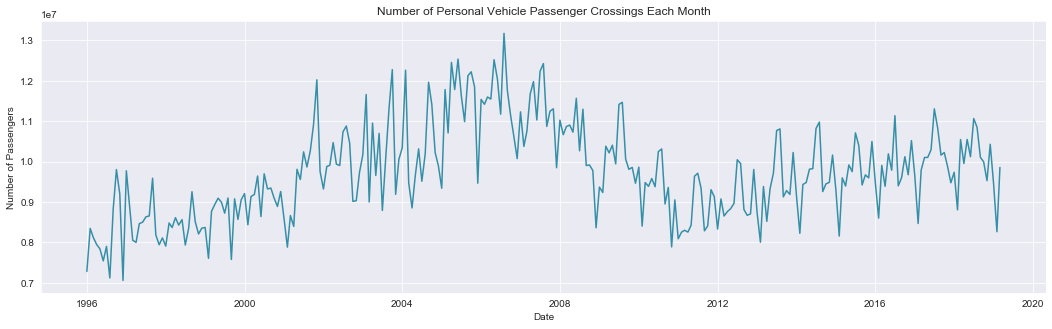

In [42]:
pt.figure(figsize=(18,5))
pov_pass = pass_move.loc['Personal Vehicle Passengers'].to_frame()
sns.lineplot(x=pov_pass.index, y='Personal Vehicle Passengers', data=pov_pass, color=pal[2])
pt.title('Number of Personal Vehicle Passenger Crossings Each Month')
pt.ylabel('Number of Passengers')
pt.xlabel('Date')

Despite the huge peaks and valleys in certain months, there is an overall trend in the plot. The total number of POV passengers was, on average, increasing until about 2006-2007 beefore it started decreasing until about 2010-2011. This might be caused by the 2008 stock market crash in the United States (and in North America in general) since people became more reserved with their money and leisure travel. This would've especially impacted the ports close to shopping centres (i.e. Buffalo, NY ports and San Diego, CA ports) since less Canadians and Mexicans wanted to cross the border to do shopping. 

For example, let's take a closer look at the San Ysidro port in San Diego, CA which is the 4th busiest land border in the world. It connects Tijuana and San Diego. We'll consider POV and POV passengers.

In [43]:
code = 2504 # San Ysidro found from a quick Google search
sd_pov_pass = df[(df.Code == code) & (df.Measure.isin(['Personal Vehicles', 'Personal Vehicle Passengers']))]
sd_pov_pass

,Name,State,Code,Border,Date,Measure,Value,Location
277,San Ysidro,California,2504,Mexico,2019-03-01,Personal Vehicles,1208832,POINT (-117.02666999999998 32.54306)
949,San Ysidro,California,2504,Mexico,2019-02-01,Personal Vehicles,1039184,POINT (-117.02666999999998 32.54306)
1889,San Ysidro,California,2504,Mexico,2019-01-01,Personal Vehicles,1164766,POINT (-117.02666999999998 32.54306)
3065,San Ysidro,California,2504,Mexico,2018-12-01,Personal Vehicles,1123026,POINT (-117.02666999999998 32.54306)
3422,San Ysidro,California,2504,Mexico,2018-11-01,Personal Vehicles,1090239,POINT (-117.02666999999998 32.54306)
...,...,...,...,...,...,...,...,...
343938,San Ysidro,California,2504,Mexico,1996-03-01,Personal Vehicle Passengers,0,POINT (-117.03 32.54)
344638,San Ysidro,California,2504,Mexico,1996-02-01,Personal Vehicle Passengers,0,POINT (-117.03 32.54)
344663,San Ysidro,California,2504,Mexico,1996-02-01,Personal Vehicles,0,POINT (-117.03 32.54)
345646,San Ysidro,California,2504,Mexico,1996-01-01,Personal Vehicles,0,POINT (-117.03 32.54)


We are clearly missing records for certain dates so we will use only POV to maintain completeness. Note that this was not clear before, and a heuristic can be applied to fill in missing records. However, I suspect that this is true for all ports and it will require significant effort to determine values that won't negatively skew our results. 

Let's plot what we have:

Text(0.5, 0, 'Date')

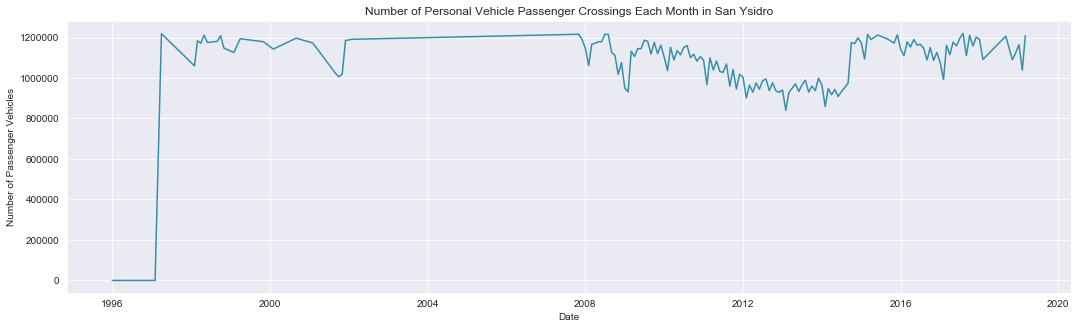

In [44]:
pt.figure(figsize=(18,5))
sns.lineplot(x='Date', y='Value', data=sd_pov_pass.loc[sd_pov_pass.Measure == 'Personal Vehicles'], color=pal[2])
pt.title('Number of Personal Vehicle Passenger Crossings Each Month in San Ysidro')
pt.ylabel('Number of Passenger Vehicles')
pt.xlabel('Date')

From the above plot, we see the impacts of missing data points for the early 2000s. The sharp rise after 1996 explains the opening of the port. As expected, soon after 2008 started, there is a steady decline in the number of passenger vehicle crossings until about 2014 thus agreeing with our previous plot that ports near shopping centres will likely show the same trend.  

Before moving on, let's check one more thing: how does the type of movement correlate with each other?

In [45]:
corr_df = df[['Date', 'Measure', 'Value']].pivot_table('Value', index='Date', columns='Measure', aggfunc='sum')
corr_df.index = corr_df.index.year
corr_df.head()

Measure,Bus Passengers,Buses,Pedestrians,Personal Vehicle Passengers,Personal Vehicles,Rail Containers Empty,Rail Containers Full,Train Passengers,Trains,Truck Containers Empty,Truck Containers Full,Trucks
Date,,,,,,,,,,,,
1996,299911,17873,3138859,7280932,5132210,22422,44353,13803,3084,130941,311889,674351
1996,320976,18566,2994503,8346739,5042578,21602,42141,12643,3175,120938,263897,692353
1996,359668,21551,3508484,8120721,5641942,26677,46848,13769,3465,128635,278244,719027
1996,454548,23346,3085717,7947652,5438523,23280,42915,16904,3292,123626,281492,690452
1996,562319,27565,2945140,7839736,5854067,23013,41777,17564,3363,139160,280927,758423


Let's look at a pairplot for only passenger movement first:

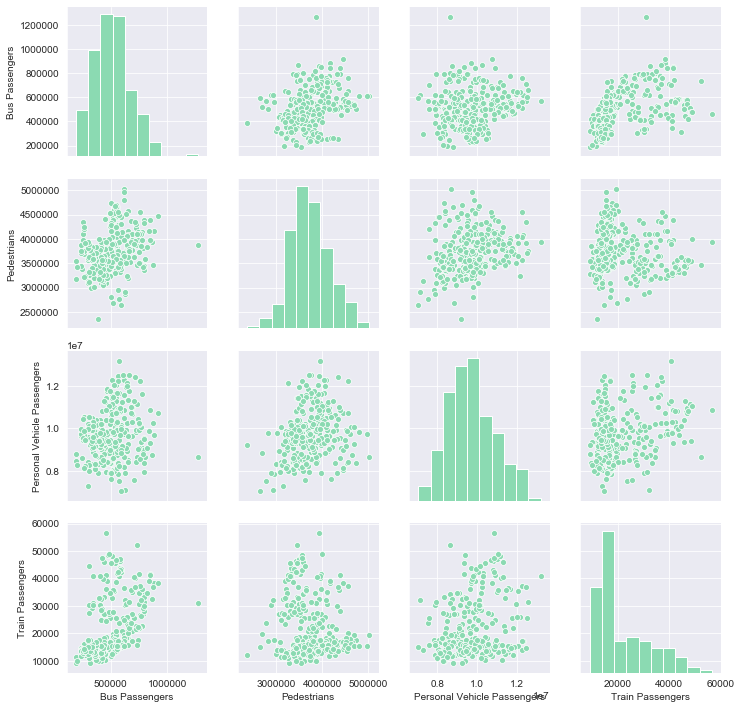

In [46]:
sns.set_palette('mako_r')
sns.pairplot(corr_df[people])

Now for all commercial vehicles:

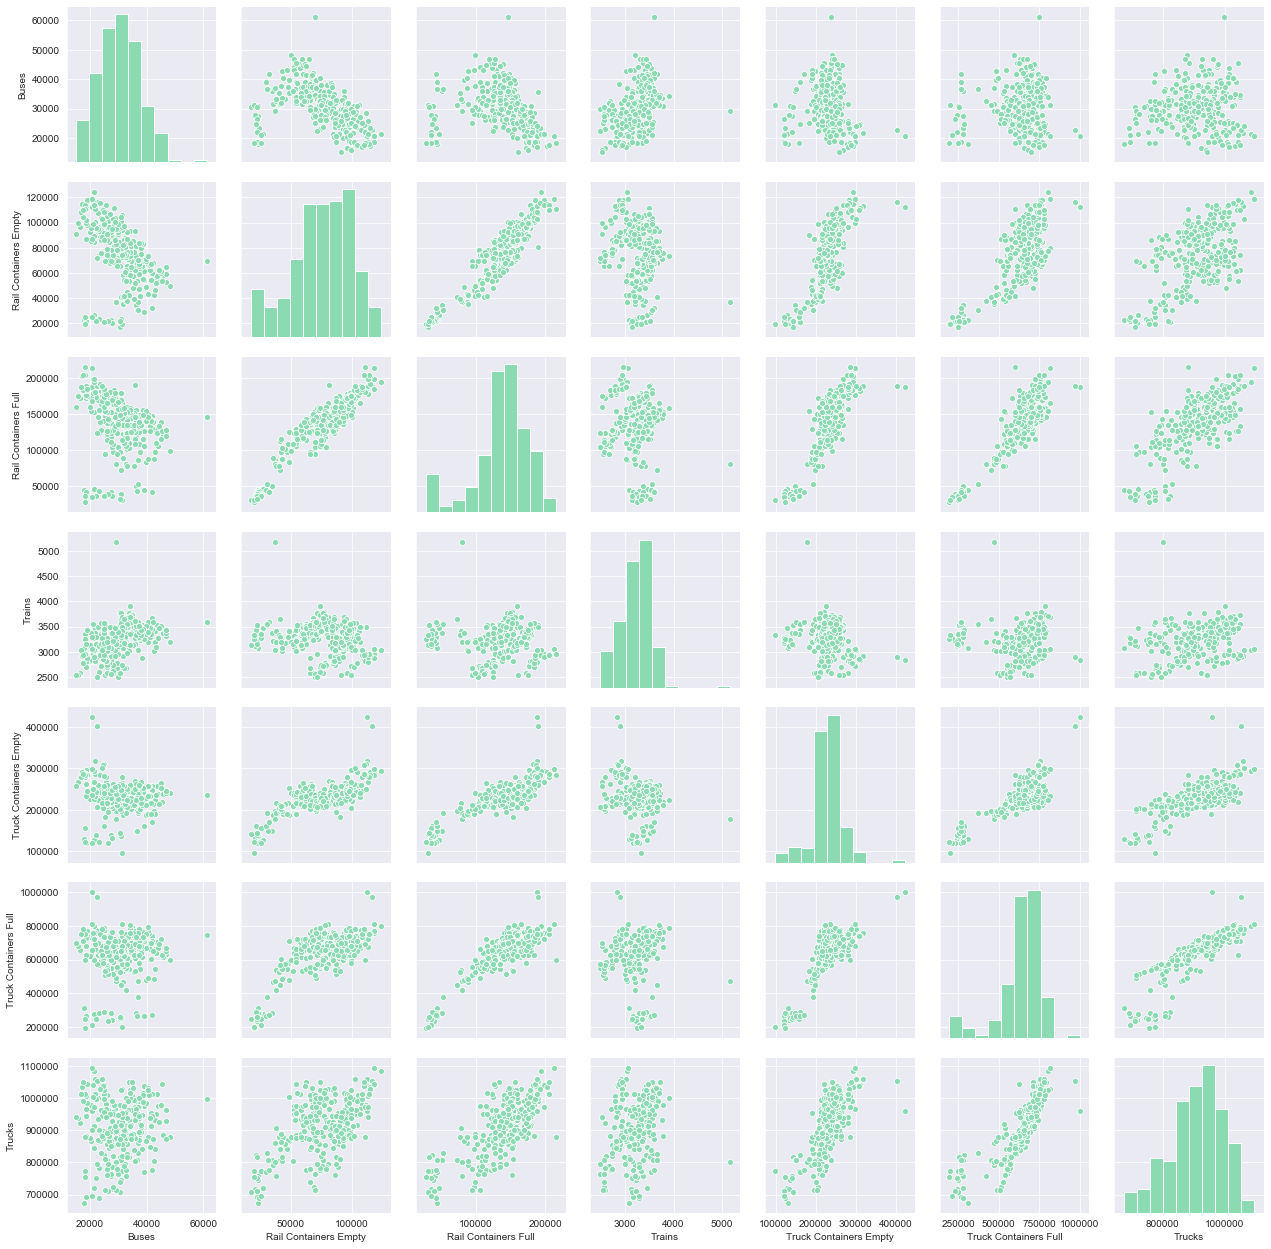

In [47]:
sns.pairplot(corr_df[commercial])

Suppose we now look at a correlation plot with the correlation values only:

In [48]:
corr_df.corr().style.background_gradient(cmap='mako_r').set_precision(3)

Measure,Bus Passengers,Buses,Pedestrians,Personal Vehicle Passengers,Personal Vehicles,Rail Containers Empty,Rail Containers Full,Train Passengers,Trains,Truck Containers Empty,Truck Containers Full,Trucks
Measure,,,,,,,,,,,,
Bus Passengers,1,0.915,0.328,0.141,0.123,-0.474,-0.33,0.434,0.495,-0.188,-0.0435,0.0509
Buses,0.915,1,0.431,0.184,0.154,-0.451,-0.279,0.331,0.453,-0.138,0.0445,0.0825
Pedestrians,0.328,0.431,1,0.235,0.204,-0.0333,0.187,-0.114,0.319,0.173,0.324,0.298
Personal Vehicle Passengers,0.141,0.184,0.235,1,0.236,0.357,0.427,0.255,0.229,0.325,0.52,0.42
Personal Vehicles,0.123,0.154,0.204,0.236,1,0.359,0.369,0.319,0.0017,0.448,0.346,0.24
Rail Containers Empty,-0.474,-0.451,-0.0333,0.357,0.359,1,0.913,0.111,-0.234,0.772,0.711,0.558
Rail Containers Full,-0.33,-0.279,0.187,0.427,0.369,0.913,1,0.084,-0.0439,0.801,0.863,0.729
Train Passengers,0.434,0.331,-0.114,0.255,0.319,0.111,0.084,1,0.0936,0.197,0.106,0.181
Trains,0.495,0.453,0.319,0.229,0.0017,-0.234,-0.0439,0.0936,1,-0.157,0.11,0.286


#### Mexico vs Canada

First let's see how much both borders contribute to total number of crossings over the year:

In [49]:
col = ['Date', 'Border', 'Value']
mexcan = df[col]
mexcan['Year'] = mexcan.Date.dt.year
mexcan = mexcan.groupby(['Year', 'Border']).sum()
mexcan.reset_index(inplace=True)
mexcan

,Year,Border,Value
0,1996,Canada,63279694
1,1996,Mexico,158134950
2,1997,Canada,64027098
3,1997,Mexico,181497237
4,1998,Canada,66060995
5,1998,Mexico,194037239
6,1999,Canada,67943038
7,1999,Mexico,197251499
8,2000,Canada,70281277
9,2000,Mexico,202548718


Text(0, 0.5, 'Number of Crossings')

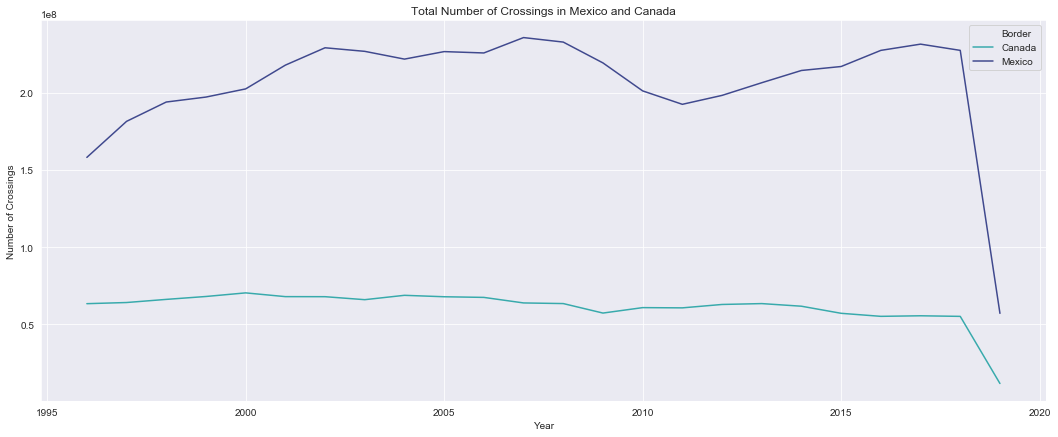

In [50]:
pt.figure(figsize=(18,7))
sns.lineplot(x='Year', y='Value', data=mexcan, hue='Border', palette='mako_r')
pt.title('Total Number of Crossings in Mexico and Canada')
pt.ylabel('Number of Crossings')

From the above plot, Canada has maintained a relatively constant number of total crossings throughout the years. On the other hand, Mexican crossings have steadily been on the rise from 1996 to around 2008. This might be explained by the growth in the Mexican economy due to increased trade with the US, and the increase of its developed population who are able to afford travel to the US. 

Both countries experience a decrease around the 2008 recession as mentioned above, however Mexico feels it at a much greater magnitude. This could be because of its heavy reliance on the US as a trade partner whereas Canada has less of a dependence. Starting in 2011, Mexico experiences growth in the number of crossings extending until now. 

The extreme dip in 2019 for both countries occurs because the dataset only contains crossing data until March, so the overall sum of 2019 is much less than previous years.

Let's take a closer look at growth rates:

In [51]:
mexcan['Growth'] = 0
for country in ['Mexico', 'Canada']:
    for y in range(1996, 2018):
        old = mexcan.loc[(mexcan.Year == y) & (mexcan.Border == country)].Value
        new = mexcan.loc[(mexcan.Year == y + 1) & (mexcan.Border == country)].Value
        growth = round((int(new)/int(old) - 1)*100, 2)
        mexcan.at[((mexcan.Year == y) & (mexcan.Border == country)), 'Growth'] = growth

mexcan.head()

,Year,Border,Value,Growth
0,1996,Canada,63279694,1.18
1,1996,Mexico,158134950,14.77
2,1997,Canada,64027098,3.18
3,1997,Mexico,181497237,6.91
4,1998,Canada,66060995,2.85


Text(0.5, 1.0, 'Annual Crossing Growth by Year')

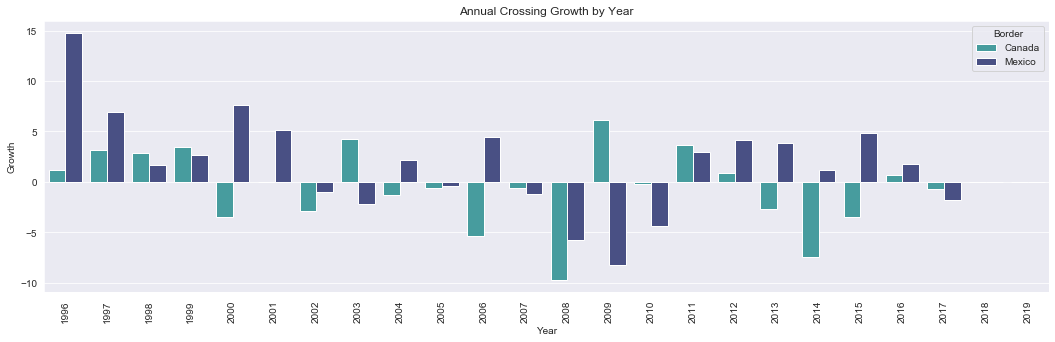

In [52]:
pt.figure(figsize=(18,5))
sns.barplot(x='Year', y='Growth', data=mexcan, hue='Border', palette='mako_r')
pt.xticks(rotation=90)
pt.title('Annual Crossing Growth by Year')

The above plot confirms what we have discovered previously about the data. Mexico experiences significant growth in 1996 which continued, albeit at a slower rate, until 2008 when it started declining. Conversely, Canada has experience pretty inconsistent growth rates, allowing for a consistent number of crossings throughout the years. The only exception to is in 2008.



#### What about States?

Let's figure out which states have the most border crossings. Now due to the geography of the US, one state can only share a border with exactly one of Mexico or Canada.

Text(0.5, 1.0, 'Violin Plot of Border Crossings by State')

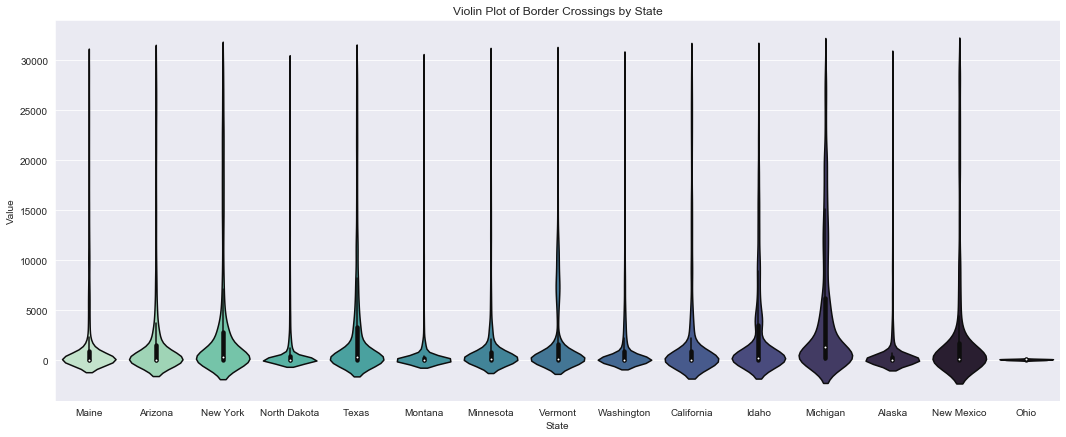

In [53]:
pt.figure(figsize=(18,7))
sns.violinplot(x='State', y='Value',data=df[df.Value <= 30000], scale='width', palette='mako_r')
pt.title('Violin Plot of Border Crossings by State')

From the above graphs, we can see that Texas, California and New Mexico have the largest range of possible values of the borders facing Mexico. On the other hand, New York, Idaho and Michigan have the same attribute of the states bordering Canada. The mean is roughly the same across all states for both Mexico and Canada, except for Michigan which has a slightly higher value. This might be because of the large number of commercial vehicles crossing through Ontario to Michigan, both heavily industrialized. 

Text(0.5, 1.0, 'Violin Plot of Border Crossings in Michigan by Movement Type')

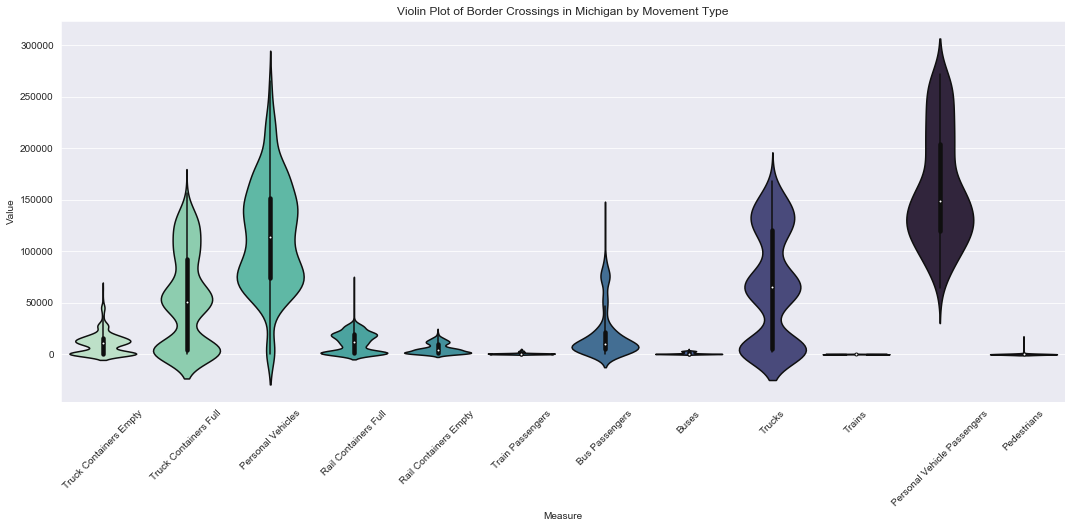

In [54]:
pt.figure(figsize=(18,7))
sns.violinplot(x='Measure', y='Value',data=df[df.State == 'Michigan'], scale='width', palette='mako_r')
pt.xticks(rotation=45)
pt.title('Violin Plot of Border Crossings in Michigan by Movement Type')

We expect POV and POV passengers to lead, as with all states. However, looking at Truck and Truck Containers Full, it is evident that the mean Value is higher than most other movement types. However Trucks is trimodal and Truck Containers Full is bimodal which implies that some years, Michigan in fact saw low number of commercial border crossings by trucks.

### Conclusion

To conclude, we explored some relationships within our data today to gain a better understanding and then visualized it to find any trends. The next step is trying to answer the following question:

Can we predict the number of border crossings given the location, type of movement and month? 